#Partie création des masks et calcul de la fonction loss d'histogramme

## Import

In [12]:
from google.colab.patches import cv2_imshow
import os
# os.environ['CUDA_VISIBLE_DEVICES']='0'
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import pickle
import dlib
import cv2
import numpy as np
import os
import time
import random
import tarfile

batch_size = 1
gpu_num = 2
max_images = 1050
pool_size = 50

img_height = 256
img_width = 256
img_layer = 3

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17689141525044631017
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10775964009059631641
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17217948514679926440
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7470045594
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3778746393105198324
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


## Fonctions diverses

### get_mask

In [0]:
def get_mask(input_face, detector, predictor,window=5):
        
        gray = cv2.cvtColor(input_face, cv2.COLOR_BGR2GRAY)
        dets = detector(gray, 1)

        for face in dets:
            shape = predictor(input_face, face)
            temp = []
            for pt in shape.parts():
                temp.append([pt.x, pt.y])
            lip_mask = np.zeros([256, 256])
            eye_mask = np.zeros([256,256])
            face_mask = np.full((256, 256), 255).astype(np.uint8)
            cv2.fillPoly(lip_mask, [np.array(temp[48:60]).reshape((-1, 1, 2))], (255, 255, 255))
            cv2.fillPoly(lip_mask, [np.array(temp[60:68]).reshape((-1, 1, 2))], (0, 0, 0))

            left_left = min(x[0] for x in temp[36:42])
            left_right = max(x[0] for x in temp[36:42])
            left_bottom = min(x[1] for x in temp[36:42])
            left_top = max(x[1] for x in temp[36:42])
            left_rectangle = np.array(
                [[left_left - window, left_top + window], [left_right + window, left_top + window],
                 [left_right + window, left_bottom - window], [left_left - window, left_bottom - window]]
            ).reshape((-1, 1, 2))
            cv2.fillPoly(eye_mask, [left_rectangle], (255, 255, 255))
            cv2.fillPoly(eye_mask, [np.array(temp[36:42]).reshape((-1, 1, 2))], (0, 0, 0))

            right_left = min(x[0] for x in temp[42:48])
            right_right = max(x[0] for x in temp[42:48])
            right_bottom = min(x[1] for x in temp[42:48])
            right_top = max(x[1] for x in temp[42:48])
            right_rectangle = np.array(
                [[right_left - window, right_top + window], [right_right + window, right_top + window],
                 [right_right + window, right_bottom - window], [right_left - window, right_bottom - window]]
            ).reshape((-1, 1, 2))
            cv2.fillPoly(eye_mask, [right_rectangle], (255, 255, 255))
            cv2.fillPoly(eye_mask, [np.array(temp[42:47]).reshape((-1, 1, 2))], (0, 0, 0))

            cv2.polylines(face_mask, [np.array(temp[17:22]).reshape(-1, 1, 2)], False, (0, 0, 0), 7)
            cv2.polylines(face_mask, [np.array(temp[22:27]).reshape(-1, 1, 2)], False, (0, 0, 0), 7)
            cv2.fillPoly(face_mask, [np.array(temp[36:42]).reshape((-1, 1, 2))], (0, 0, 0))
            cv2.fillPoly(face_mask, [np.array(temp[42:48]).reshape((-1, 1, 2))], (0, 0, 0))
            cv2.fillPoly(face_mask, [np.array(temp[48:60]).reshape((-1, 1, 2))], (0, 0, 0))
            return lip_mask,eye_mask,face_mask

### get_mask_with_color

In [0]:

def get_mask_with_color(lip_mask,eye_mask,face_mask,image):
  #print(lip_mask.shape)
  #print(image.shape)
  #print(lip_mask.shape)
  #print(image.shape)  
  lip_mask = np.uint8(lip_mask)
  eye_mask = np.uint8(eye_mask)
  face_mask = np.uint8(face_mask)
  image = np.uint8(image)
  image_lip_mask = cv2.bitwise_or(image,image, mask = lip_mask)
  image_eye_mask = cv2.bitwise_or(image,image, mask = eye_mask)
  image_face_mask = cv2.bitwise_or(image,image, mask = face_mask)

  #cv2_imshow(image_lip_mask)
  #cv2_imshow(image_eye_mask)
  #cv2_imshow(image_face_mask)
  return image_lip_mask,image_eye_mask,image_face_mask
#get_mask_with_color(lip_mask,eye_mask,face_mask,image1)

### calc_hist3 with 3 channels

In [0]:
def calc_hist3 (img) : 

  hist0 = cv2.calcHist([img],[0],None,[256],[0,256])
  hist1 = cv2.calcHist([img],[1],None,[256],[0,256])
  hist2 = cv2.calcHist([img],[2],None,[256],[0,256])
  return hist0,hist1,hist2
#plt.plot(calc_hist3(img)[0])


## Fonction à comprendre

In [0]:
# source => image sourcee 
# source => image template
# source_mask => source_mask (lip ou eyes ou face)
# template_mask => template_mask (lip ou eyes ou face)
def histogram_loss_cal(source,template,source_mask,template_mask):
    shape = tf.shape(source)
    source = tf.reshape(source, [1, -1])
    template = tf.reshape(template, [1, -1])
    source_mask = tf.reshape(source_mask,[-1, 256 * 256])
    template_mask = tf.reshape(template_mask,[-1,256*256])

    source = tf.boolean_mask(source, source_mask)
    template = tf.boolean_mask(template, template_mask)

    his_bins = 255

    max_value = tf.reduce_max([tf.reduce_max(source), tf.reduce_max(template)])
    min_value = tf.reduce_min([tf.reduce_min(source), tf.reduce_min(template)])

    hist_delta = (max_value - min_value) / his_bins
    hist_range = tf.range(min_value, max_value, hist_delta)
    hist_range = tf.add(hist_range, tf.divide(hist_delta, 2))

    s_hist = tf.histogram_fixed_width(source, [min_value, max_value], his_bins, dtype=tf.int32)
    t_hist = tf.histogram_fixed_width(template, [min_value, max_value], his_bins, dtype=tf.int32)

    s_quantiles = tf.cumsum(s_hist)
    s_last_element = tf.subtract(tf.size(s_quantiles), tf.constant(1))
    s_quantiles = tf.divide(s_quantiles, tf.gather(s_quantiles, s_last_element))

    t_quantiles = tf.cumsum(t_hist)
    t_last_element = tf.subtract(tf.size(t_quantiles), tf.constant(1))
    t_quantiles = tf.divide(t_quantiles, tf.gather(t_quantiles, t_last_element))

    nearest_indices = tf.map_fn(lambda x: tf.argmin(tf.abs(tf.subtract(t_quantiles, x))), s_quantiles,
                                dtype=tf.int64)
    s_bin_index = tf.to_int64(tf.divide(source, hist_delta))
    s_bin_index = tf.clip_by_value(s_bin_index, 0, 254)

    matched_to_t = tf.gather(hist_range, tf.gather(nearest_indices, s_bin_index))
    # Using the same normalization as Gatys' style transfer: A huge variation--the normalization scalar is different according to different image
    # normalization includes variation constraints may be better
    matched_to_t = tf.subtract(tf.div(matched_to_t,127.5),1)
    source = tf.subtract(tf.divide(source,127.5),1)
    return tf.reduce_mean(tf.squared_difference(matched_to_t,source))


# Test des Fonctions


### get_mask

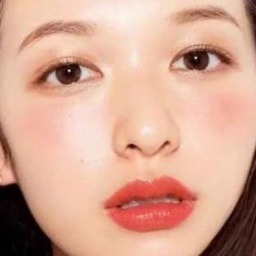

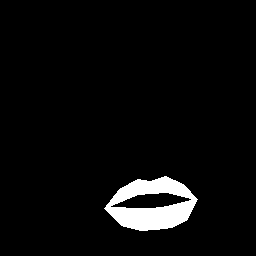

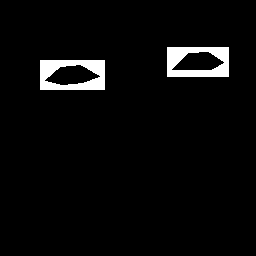

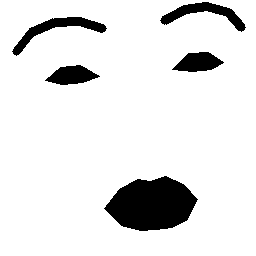

In [17]:

input_face  =cv2.imread("140.jpg")
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()
lip_mask,eye_mask,face_mask = get_mask(input_face, detector, predictor,window=5)
cv2_imshow(input_face)
cv2_imshow(lip_mask)
cv2_imshow(eye_mask)
cv2_imshow(face_mask)

## get_mask_with_color

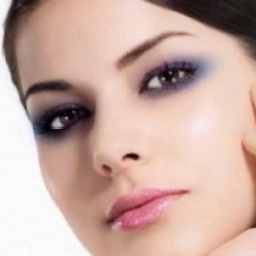

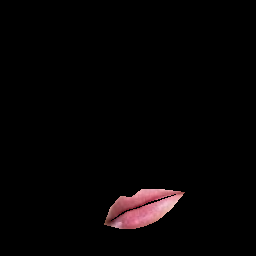

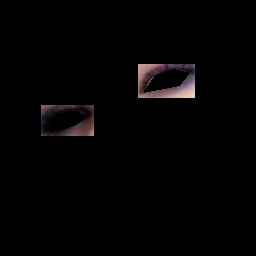

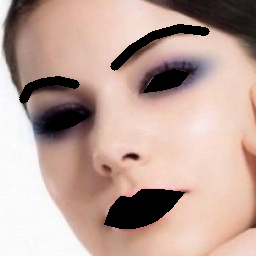

In [63]:
# pour l'image 1 
image1 = cv2.imread("/content/1.jpg",cv2.IMREAD_UNCHANGED)
lip_mask1,eye_mask1,face_mask1 = get_mask(image1, detector, predictor,window=5)
lip_mask1_color,eye_mask1_color,face_mask1_color= get_mask_with_color(lip_mask1,eye_mask1,face_mask1,image1)
cv2_imshow(image1)
cv2_imshow(lip_mask1_color)
cv2_imshow(eye_mask1_color)
cv2_imshow(face_mask1_color)

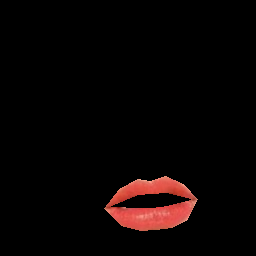

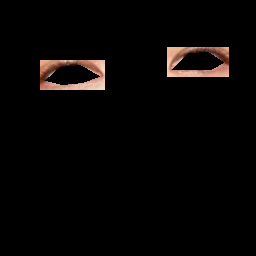

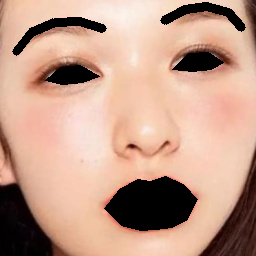

In [19]:
# pour l'image 2
image2 = cv2.imread("/content/140.jpg",cv2.IMREAD_UNCHANGED)
lip_mask2,eye_mask2,face_mask2 = get_mask(image2, detector, predictor,window=5)
lip_mask2_color,eye_mask2_color,face_mask2_color= get_mask_with_color(lip_mask2,eye_mask2,face_mask2,image2)
cv2_imshow(lip_mask2_color)
cv2_imshow(eye_mask2_color)
cv2_imshow(face_mask2_color)

In [0]:
img = cv2.imread('140.jpg')
hist = cv2.calcHist([img],[2],None,[256],[0,256])

## Calc_hist3 with 3 channels


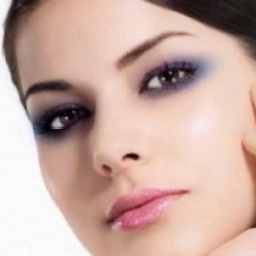

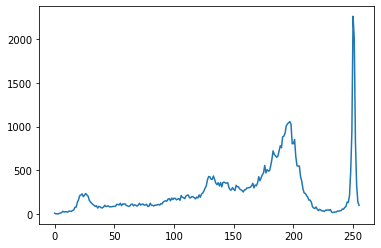

In [21]:
plt.plot(calc_hist3(image1)[0])
cv2_imshow(image1)

## But des histogrammes 

faire des différences entre les hist mask et essayer de les minimiser.
exemple : 

In [0]:

def calc_diff(hist3channels_1,hist3channels_2) : 
  return  (hist3channels_1[0] - hist3channels_2[0])**2+(hist3channels_1[1]- hist3channels_2[1])**2+ (hist3channels_1[2] -  hist3channels_2[2])**2

def loss_hist(hist3channels_1,hist3channels_2):
  diff_hist = np.sum(calc_diff(hist3channels_1,hist3channels_2))
  tf_hist = tf.convert_to_tensor(diff_hist)
  return(calc_diff(hist3channels_1,hist3channels_2)

we want to minimize : 128770.0


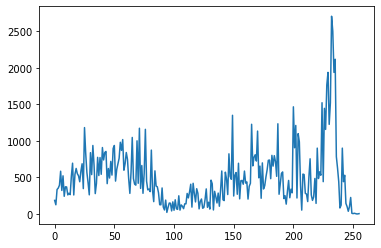

In [101]:
# faire des différences entre les mask et essayer de les minimiser
hist3channels_1 = calc_hist3(eye_mask1_color)
hist3channels_2 = calc_hist3(eye_mask2_color)
plt.plot(calc_diff(hist3channels_1,hist3channels_2))

diff_hist = np.sum(calc_diff(hist3channels_1,hist3channels_2))
print("we want to minimize :",diff_hist)
tf_hist = tf.convert_to_tensor(diff_hist)



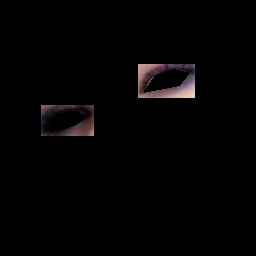

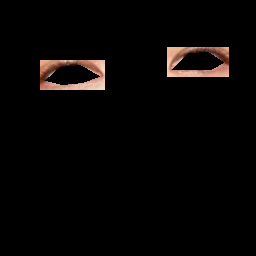

10


In [102]:
cv2_imshow(eye_mask1_color)
cv2_imshow(eye_mask2_color)
print("10")

## Loss function of diff hist

In [50]:
hist3channels_1 = calc_hist3(lip_mask1_color)
hist3channels_2 = calc_hist3(lip_mask2_color)

def hist_loss_function(hist3channels_1 , hist3channels_2) : 
  
  hist3channels_1 = np.array(hist3channels_1)
  hist3channels_2 = np.array(hist3channels_2)

  mse = tf.keras.losses.MeanSquaredError()
  hist3channels_1 = hist3channels_1.reshape(3*256)
  hist3channels_2 = hist3channels_2.reshape(3*256)

  return  mse(list(hist3channels_1), list(hist3channels_2))
print('Loss: ', loss)  # Loss: 0.75


Loss:  Tensor("mean_squared_error_18/weighted_loss/value:0", shape=(), dtype=float32)


In [70]:
  print(tf.reduce_mean(hist3channels_1,hist3channels_2,axis = 1))


TypeError: ignored

In [92]:
hist3channels_1

AttributeError: ignored

In [97]:
sum = 0
for elem in hist3channels_1 :
  print(elem)
  sum = sum + elem 
sum = sum 
print(sum/256)

63538.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
2.0
1.0
0.0
0.0
0.0
2.0
3.0
0.0
1.0
2.0
0.0
1.0
3.0
1.0
4.0
4.0
1.0
4.0
2.0
2.0
5.0
3.0
2.0
6.0
4.0
4.0
5.0
3.0
1.0
3.0
7.0
6.0
5.0
3.0
4.0
7.0
7.0
7.0
12.0
8.0
8.0
6.0
4.0
10.0
13.0
4.0
9.0
4.0
7.0
13.0
4.0
7.0
15.0
7.0
3.0
5.0
4.0
10.0
8.0
10.0
10.0
13.0
6.0
17.0
15.0
14.0
19.0
16.0
12.0
10.0
14.0
11.0
15.0
16.0
13.0
21.0
11.0
12.0
12.0
29.0
13.0
16.0
21.0
22.0
22.0
14.0
21.0
17.0
23.0
16.0
14.0
19.0
21.0
20.0
10.0
15.0
33.0
20.0
24.0
15.0
24.0
23.0
21.0
17.0
26.0
19.0
22.0
20.0
21.0
18.0
19.0
15.0
12.0
14.0
22.0
13.0
17.0
23.0
17.0
19.0
23.0
18.0
12.0
11.0
19.0
11.0
13.0
18.0
14.0
22.0
19.0
21.0
13.0
18.0
20.0
23.0
19.0
21.0
19.0
21.0
20.0
24.0
18.0
15.0
24.0
14.0
17.0
17.0
11.0
8.0
6.0
7.0
11.0
6.0
5.0
8.0
10.0
9.0
8.0
6.0
7.0
7.0
8.0
0.0
5.0
1.0
9.0
2.0
2.0
5.0
4.0
1.0
1.0
2.0
1.0
1.0
4.0
3.0
2.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0